In [1]:
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F

/Users/nscherf/miniconda3/envs/dgl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Build an example of semi-supervised node classification. 

In [2]:
dataset = dgl.data.CoraGraphDataset()
print(f"Number of categories: {dataset.num_classes}")

/Users/nscherf/.dgl/cora_v2.zip: 100%|██████████| 132k/132k [00:00<00:00, 44.2MB/s]


Extracting file to /Users/nscherf/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7


In [3]:
len(dataset)

1

In [4]:
g = dataset[0]

In [6]:
g.ndata.keys()

dict_keys(['train_mask', 'val_mask', 'test_mask', 'label', 'feat'])

In [7]:
print("node features")
print(g.ndata['feat'])
print("node labels")
print(g.ndata['label'])

node features
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
node labels
tensor([3, 4, 4,  ..., 3, 3, 3])


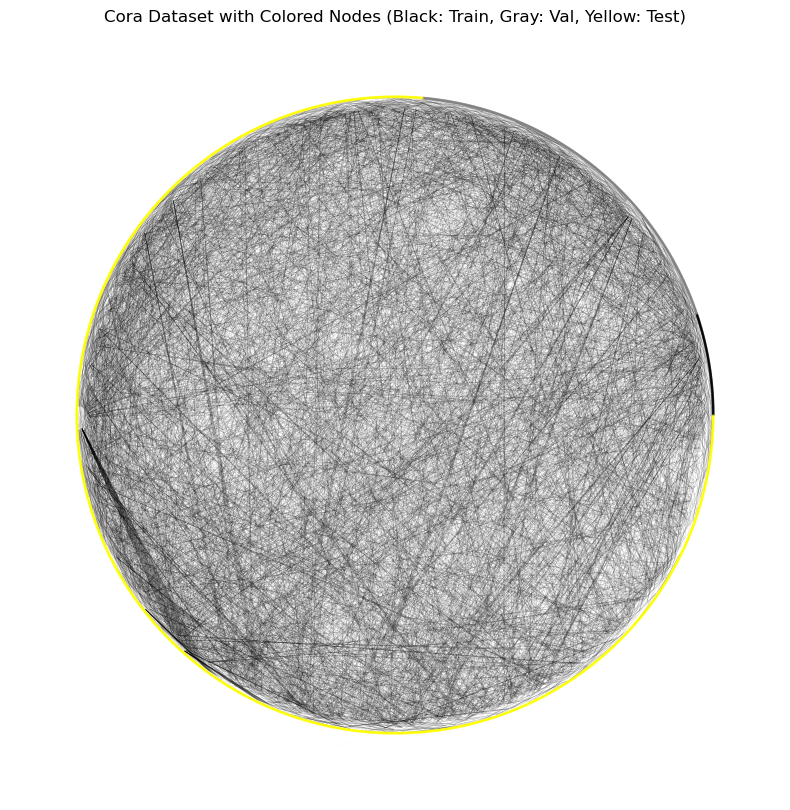

In [37]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Convert DGL graph to networkx graph
nx_g = g.to_networkx().to_undirected()

# Assign random colors to edges for demonstration
# In practice, you might use edge features or other criteria
edge_colors = np.random.rand(g.num_edges(), 3)  # RGB colors

# Extract masks
train_mask = g.ndata['train_mask'].numpy()
val_mask = g.ndata['val_mask'].numpy()
test_mask = g.ndata['test_mask'].numpy()

# Assign colors based on the masks
node_colors = np.where(train_mask, 'black', np.where(val_mask, 'gray', 'yellow'))


# Generate positions for nodes in a ring layout
pos = nx.circular_layout(nx_g, scale=10)

plt.figure(figsize=(10, 10)) 
# Draw nodes
nx.draw_networkx_nodes(nx_g, pos, node_size=1, node_color=node_colors, alpha=0.5)

# Draw edges with the assigned colors
edges = nx_g.edges()
colors = [edge_colors[i] for i, _ in enumerate(edges)]
nx.draw_networkx_edges(nx_g, pos, edgelist=edges, width=0.1, alpha=0.5)

plt.title('Cora Dataset with Colored Nodes (Black: Train, Gray: Val, Yellow: Test)')
plt.axis('off')  # Turn off the axis
plt.gca().set_aspect('equal', adjustable='box')  # Fix aspect ratio
plt.show()


In [9]:
print(g.edata)

{}


In [10]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [11]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        logits = model(g, features)
        pred = logits.argmax(1)
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(f"Epoch: {e}, Loss: {loss}, Train accuracy: {train_acc}, Val accuracy: {val_acc}, Test accuracy: {test_acc}")

model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)


Epoch: 0, Loss: 1.9459667205810547, Train accuracy: 0.15714286267757416, Val accuracy: 0.14800000190734863, Test accuracy: 0.14399999380111694
Epoch: 5, Loss: 1.8930792808532715, Train accuracy: 0.6928571462631226, Val accuracy: 0.5519999861717224, Test accuracy: 0.5759999752044678
Epoch: 10, Loss: 1.8115625381469727, Train accuracy: 0.8642857074737549, Val accuracy: 0.6179999709129333, Test accuracy: 0.6399999856948853
Epoch: 15, Loss: 1.7063400745391846, Train accuracy: 0.8785714507102966, Val accuracy: 0.6119999885559082, Test accuracy: 0.6320000290870667
Epoch: 20, Loss: 1.5788606405258179, Train accuracy: 0.8857142925262451, Val accuracy: 0.6579999923706055, Test accuracy: 0.6800000071525574
Epoch: 25, Loss: 1.4329876899719238, Train accuracy: 0.9214285612106323, Val accuracy: 0.6880000233650208, Test accuracy: 0.7080000042915344
Epoch: 30, Loss: 1.2726044654846191, Train accuracy: 0.949999988079071, Val accuracy: 0.6980000138282776, Test accuracy: 0.7260000109672546
Epoch: 35, Lo

In [45]:
def get_test_predictions(g, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        logits = model(g, g.ndata['feat'])  # Get logits for all nodes
        test_logits = logits[g.ndata['test_mask']]  # Select logits for test nodes
        test_predictions = torch.argmax(test_logits, dim=1)  # Get predicted classes
    return test_predictions

# Assuming 'g' is your graph and 'model' is your trained GCN model
test_predictions = get_test_predictions(g, model)
print("Test set predictions:", test_predictions)

Test set predictions: tensor([3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
        2, 1, 2, 1, 2, 2, 2, 2, 2, 5, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 0, 5, 4, 4, 0, 1, 1, 1, 1, 1, 1, 6,
        2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5,
        5, 5, 2, 2, 2, 2, 2, 6, 6, 3, 0, 0, 0, 0, 5, 0, 0, 0, 3, 0, 0, 6, 0, 0,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 4, 4, 4, 4, 4, 3, 2, 5, 5, 5, 5,
        6, 5, 5, 5, 5, 4, 4, 4, 0, 0, 1, 0, 3, 0, 6, 6, 6, 6, 6, 6, 3, 0, 0, 0,
        0, 0, 0, 0, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
        6, 6, 0, 6, 6, 5, 5, 5, 5, 5, 5, 0, 4, 0, 3, 3, 3, 2, 2, 1, 2, 3, 3, 3,
        3, 3, 1, 3

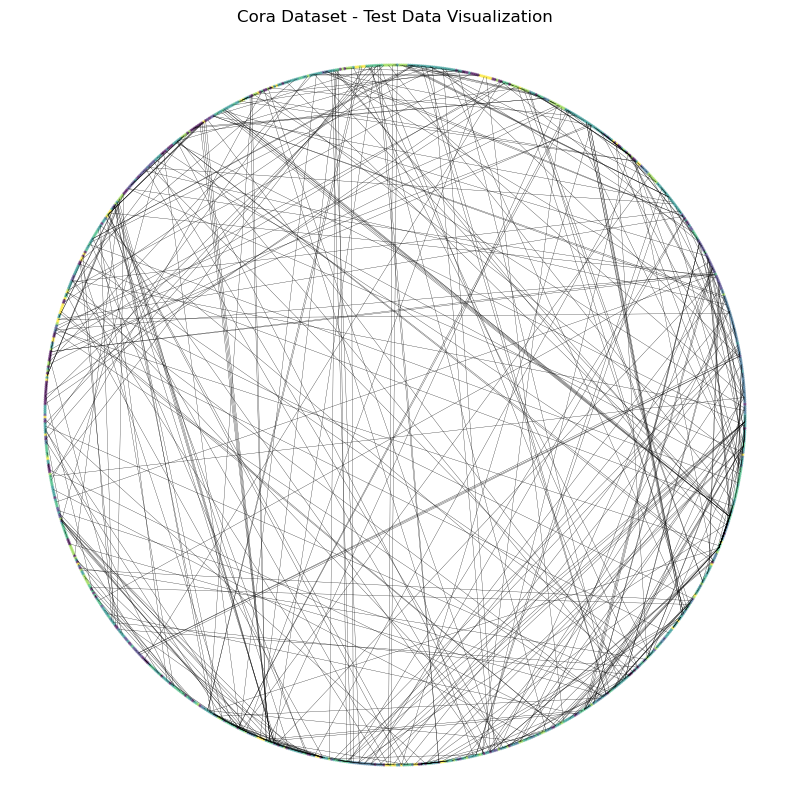

In [57]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming 'g' is your DGL Graph and it has 'test_mask'

# Convert DGL graph to networkx graph
nx_g = g.to_networkx().to_undirected()

# Extract node labels and test mask
node_labels = g.ndata['label'].numpy()
test_mask = g.ndata['test_mask'].numpy()

# Filter nodes by test mask
test_nodes = np.where(test_mask)[0]

# Create a subgraph with only test nodes
subgraph = nx_g.subgraph(test_nodes)

# Node colors - mapping labels to colors for test nodes
unique_labels = np.unique(node_labels[test_mask])
color_map = plt.get_cmap('viridis', len(unique_labels))
label_colors = color_map(node_labels[test_mask].astype(int))

# Generate positions for nodes in a ring layout
pos = nx.circular_layout(subgraph, scale=10)

plt.figure(figsize=(10, 10))

# Draw test nodes with colors based on test_predictions
nx.draw_networkx_nodes(subgraph, pos, node_size=2, node_color=label_colors, alpha=0.5)

# Create a list of lines for the edges in the subgraph
edges = [(pos[edge[0]], pos[edge[1]]) for edge in subgraph.edges()]
lc = LineCollection(edges, colors='black', linewidths=0.2, alpha=1, antialiased=True)

# Add the collection to the plot
plt.gca().add_collection(lc)

plt.title('Cora Dataset - Test Data Visualization')
plt.axis('off')  # Turn off the axis
plt.gca().set_aspect('equal', adjustable='box')  # Fix aspect ratio
plt.show()

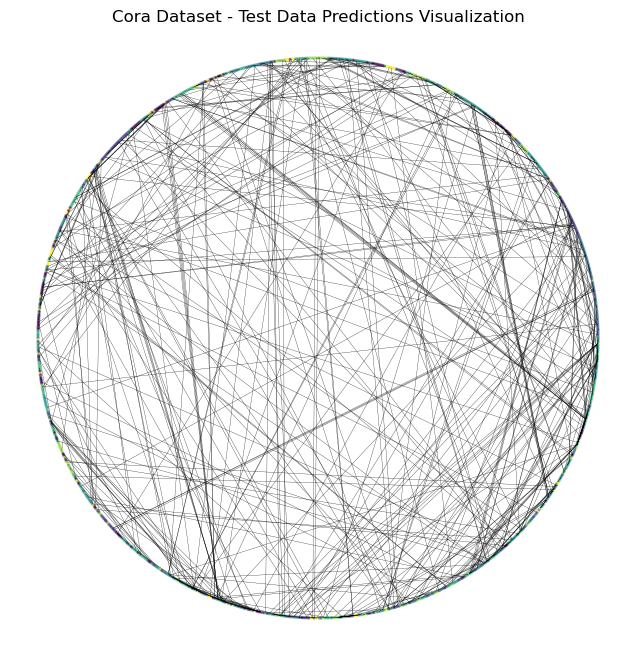

In [60]:
import dgl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import networkx as nx
import numpy as np
import torch

# Assuming 'g' is your DGL Graph, it has 'test_mask', and 'model' is your trained model

# Function to get predictions
def get_test_predictions(graph, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        logits = model(graph, graph.ndata['feat'])  # Get logits for all nodes
        test_logits = logits[graph.ndata['test_mask']]  # Select logits for test nodes
        test_predictions = torch.argmax(test_logits, dim=1)  # Get predicted classes
    return test_predictions.numpy()  # Convert to numpy for easier processing

# Get predictions for test nodes
test_predictions = get_test_predictions(g, model)

# Convert DGL graph to networkx graph
nx_g = g.to_networkx().to_undirected()

# Extract test mask
test_mask = g.ndata['test_mask'].numpy()

# Filter nodes by test mask
test_nodes = np.where(test_mask)[0]

# Create a subgraph with only test nodes
subgraph = nx_g.subgraph(test_nodes)

# Node colors - mapping test_predictions to colors for test nodes
unique_labels = np.unique(test_predictions)
color_map = plt.get_cmap('viridis', len(unique_labels))
label_colors = color_map(test_predictions.astype(int))  # Use test_predictions for colors

# Generate positions for nodes in a ring layout
pos = nx.circular_layout(subgraph, scale=10)

plt.figure(figsize=(8, 8))

# Draw test nodes with colors based on test_predictions
nx.draw_networkx_nodes(subgraph, pos, node_size=2, node_color=label_colors, alpha=0.5)

# Create a list of lines for the edges in the subgraph
edges = [(pos[edge[0]], pos[edge[1]]) for edge in subgraph.edges()]
lc = LineCollection(edges, colors='black', linewidths=0.2, alpha=1, antialiased=True)

# Add the collection to the plot
plt.gca().add_collection(lc)

plt.title('Cora Dataset - Test Data Predictions Visualization')
plt.axis('off')  # Turn off the axis
plt.gca().set_aspect('equal', adjustable='box')  # Fix aspect ratio
plt.show()

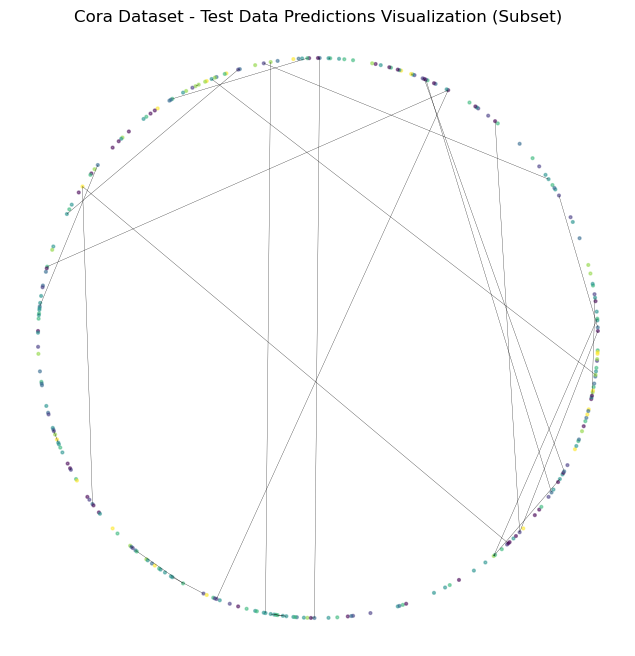

In [67]:
#Fix the random seed for reproducibility
np.random.seed(42)

# Assuming 'test_nodes' contains indices of test nodes
# Select a random subset of 100 test nodes, if there are at least 100 test nodes
num_test_nodes = len(test_nodes)
num_subset_nodes = 256  # Choose 100 or the total number of test nodes if less than 100
subset_test_nodes = np.random.choice(test_nodes, num_subset_nodes, replace=False)

# Create a subgraph with only the subset of test nodes
subgraph = nx_g.subgraph(subset_test_nodes)

# Update the node colors and positions for the subset
# Create a mapping from original test node indices to their positions in test_predictions
test_node_to_prediction_index = {node: i for i, node in enumerate(test_nodes)}

# Map subset_test_nodes to their corresponding indices in test_predictions
subset_test_node_indices = [test_node_to_prediction_index[node] for node in subset_test_nodes]

# Use the mapped indices to correctly index test_predictions
label_colors_subset = color_map(test_predictions[subset_test_node_indices].astype(int))
pos_subset = {node: pos[node] for node in subset_test_nodes}

plt.figure(figsize=(8, 8))

# Draw test nodes with colors based on test_predictions for the subset
nx.draw_networkx_nodes(subgraph, pos_subset, node_size=4, node_color=label_colors_subset, alpha=0.5)

# Create a list of lines for the edges in the subgraph of the subset
edges_subset = [(pos_subset[edge[0]], pos_subset[edge[1]]) for edge in subgraph.edges()]
lc_subset = LineCollection(edges_subset, colors='black', linewidths=0.2, alpha=1, antialiased=True)

# Add the collection to the plot
plt.gca().add_collection(lc_subset)

plt.title('Cora Dataset - Test Data Predictions Visualization (Subset)')
plt.axis('off')  # Turn off the axis
plt.gca().set_aspect('equal', adjustable='box')  # Fix aspect ratio
plt.show()